The tubes that carry fluid around the body have deformable walls. The shape of such a tube is strongly coupled to the flow within it through the internal pressure distribution. This nonlinear flow-structure interaction imparts to
such systems unusual but biologically significant properties, notably flow limitation.

To explore such interactions, one can consider a simple model system in which an incompressible fluid flows steadily through a two-dimensional channel, one wall of which is formed by a membrane under longitudinal tension. Assuming that the channel is long and thin, and that the fluid is sufficiently viscous, lubrication theory can be used to describe the flow.

Suppose the channel lies in $0 \leq y \leq h(x)$ for $0 \leq x \leq L$, where $L \gg h$. Applying no-slip and no-penetration conditions along the rigid wall $y = 0$ and the membrane $y = h$, the relationship between the steady, uniform flux $q$ of fluid along the channel and the local pressure gradient
$p_x$ is approximately $q = -h^3p_x/(12\mu)$, where $\mu$ is the fluid's viscosity, assumed constant. The fluid pressure distribution $p(x)$ is controlled by the shape of the channel wall according to $p = -Th_{xx}$, where $T$ is the tension in the membrane, assumed constant; the pressure outside the membrane is taken to be zero.

We assume that the membrane is fixed at either end, so that $h(0) = h(L) = h_0$, for some constant $h_0$. The flow is controlled by the upstream and downstream pressures $p(0) = p_u$ and $p(L) = p_d$, and characterised by the relationship between the flux $q$ and the pressure drop along the channel, $p_u - p_d$, holding either $p_u$ or $p_d$ constant.

The problem can be simplified by nondimensionalisation. Let
\begin{equation}
    h(x) = h_0H(X), \quad x = LX, \quad \text{and} \quad p(x) = p_0P(X),
\end{equation}
where $p_0 = Th_0/L^2$. This yields nondimensional parameters $Q = 12\mu L^3q/(Th_0^4)$, $P_u = p_u/p_0$, $P_d = p_d/p_0$ and governing equations
\begin{equation}
    Q = -H^3P_X, \quad P = −H_{XX} \quad (0 \leq X \leq 1),
\end{equation}
subject to
\begin{equation}
    H(0) = 1, \quad H(1) = 1, \quad P(0) = P_u, \quad P(1) = P_d.
\end{equation}
We seek graphs of $\Delta P = P_u - P_d > 0$ as a function of $Q$, for fixed values of $P_u$ or $P_d$. So only three of the four boundary conditions in are relevant.

This is a two-point, third-order, boundary-value problem. It can be solved by two different methods: shooting, which is relatively easy to program but which cannot normally be extended to problems in higher dimensions; and a direct finite-difference method, which is more complicated to set up but adaptable to more complex situations.


---

We use a Runge-Kutta routine to integrate our ODE from $X = 1$ to $X = 0$, by fixing $Q$ and $P_d$, setting $H(1) = 1$, $H'(1) = \beta$, $H''(1) = -P_d$ and then varying $\beta$ until $H(0) = 1$. If we know that a solution exists for $\beta_1 < \beta < \beta_2$, a root-finding routine will be useful in quickly homing in to the required solution. We will need to compute solutions with $P_u$ fixed, shooting from $X = 0$ to $X = 1$.

First, we must convert the governing equations into a system of three first-order differential equations. We have
\begin{equation}
    P = -H_{XX} \implies P_X = -H_{XXX}
\end{equation}
and
\begin{equation}
    Q = -H^3 P_X \implies Q = -H^3 (-H_{XXX}) = H^3 H_{XXX}
\end{equation}
Rearranging for the highest derivative
\begin{equation}
    H_{XXX} = \frac{Q}{H^3}
\end{equation}
Let $y_1 = H$, $y_2 = H'$, and $y_3 = H''$. Then the system of ODEs becomes
\begin{align}
    y_1' &= y_2, \\
    y_2' &= y_3, \\
    y_3' &= \frac{Q}{y_1^3}.
\end{align}
We integrate backwards from $1$ to $0$. At $X=1$, we know
\begin{equation}
    H(1) = 1 \implies y_1(1) = 1,
\end{equation}
and
\begin{equation}
    H''(1) = -P_d \implies y_3(1) = -P_d.
\end{equation}
The unknowns at $X=1$ are the guess parameter
\begin{equation}
    H'(1) = \beta \implies y_2(1) = \beta$,
\end{equation}
and the target at $X=0$ is
\begin{equation}
    H(0) = 1 \implies y_1(0) = 1.
\end{equation}

Shooting Method Converged. Optimal Slope H'(1): -0.00167


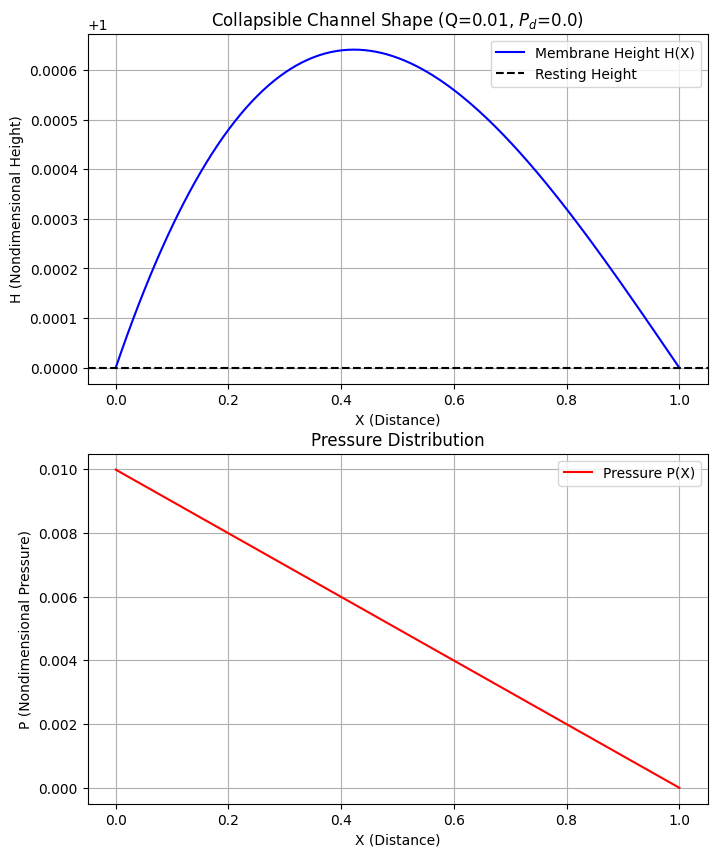

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import brentq

def solve_collapsible_tube(Q=0.01, Pd=0.0, abs_tol=1e-8, rel_tol=1e-8):

    # The system of ODEs
    def tube_ode(t, y):
        H, H_prime, H_double_prime = y
        # Physical constraint check to prevent division by zero
        if H <= 1e-6:
            H = 1e-6
        dydt = [
            H_prime,            # y0' = y1
            H_double_prime,     # y1' = y2
            Q / (H**3)          # y2' = Q/H^3
        ]
        return dydt

    # The shooting function
    def shooting_residual(beta):
        # Integration span: Backwards from X=1 to X=0
        t_span = (1.0, 0.0)
        # Initial Conditions at X=1
        # H(1) = 1, H'(1) = beta (guess), H''(1) = -Pd (Since P = -Hxx)
        y0 = [1.0, beta, -Pd]
        try:
            sol = solve_ivp(
                lambda t, y: tube_ode(t, y),
                t_span,
                y0,
                method='RK45',
                rtol=rel_tol,
                atol=abs_tol
            )
            # The result at X=0 is the last column of the solution
            H_at_0 = sol.y[0][-1]
            return H_at_0 - 1.0  # We want H(0) = 1

        except Exception:
            return 1e5

    # Find the optimal beta
    betas_to_scan = np.linspace(-10, 10, 20)
    bracket = None
    prev_res = shooting_residual(betas_to_scan[0])
    for b in betas_to_scan[1:]:
        curr_res = shooting_residual(b)
        if prev_res * curr_res < 0:
            bracket = [b - (b - betas_to_scan[0]), b] # Found crossing
            break
        prev_res = curr_res

    if bracket:
        # Use Brent's method
        beta_optimal = brentq(shooting_residual, bracket[0], bracket[1])
        print(f"Shooting Method Converged. Optimal Slope H'(1): {beta_optimal:.5f}")

        # Generate solution
        sol_final = solve_ivp(tube_ode, [1, 0], [1, beta_optimal, -Pd],
                              method='RK45', rtol=1e-9, atol=1e-9, dense_output=True)
        x_shoot = np.linspace(0, 1, 100)
        h_shoot = sol_final.sol(x_shoot)[0]
    else:
        print("Shooting Method Failed: Could not bracket the root.")
        x_shoot, h_shoot = [], []

    # Generate final solution
    t_span = (1.0, 0.0)
    y_init = [1.0, beta_optimal, -Pd]

    sol = solve_ivp(
        lambda t, y: tube_ode(t, y),
        t_span,
        y_init,
        method='RK45',
        rtol=rel_tol,
        atol=abs_tol,
        dense_output=True
    )

    # Generate smooth plotting data
    X_plot = np.linspace(0, 1, 200)
    Y_plot = sol.sol(X_plot) # Interpolated solution
    H_sol = Y_plot[0]     # H
    P_sol = -Y_plot[2]    # P = -H''

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(X_plot, H_sol, 'b-', label='Membrane Height H(X)')
    plt.axhline(1.0, color='k', linestyle='--', label='Resting Height')
    plt.title(f'Collapsible Channel Shape (Q={Q}, $P_d$={Pd})')
    plt.xlabel('X (Distance)')
    plt.ylabel('H (Nondimensional Height)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(X_plot, P_sol, 'r-', label='Pressure P(X)')
    plt.title('Pressure Distribution')
    plt.xlabel('X (Distance)')
    plt.ylabel('P (Nondimensional Pressure)')
    plt.grid(True)
    plt.legend()

    plt.show()

solve_collapsible_tube()

Writing the ODE in the form $H_{XXX}H^3 = Q$, the finite-difference method involves discretising this equation and the boundary conditions with second-order accurate finite differences on a uniform $N$-node grid with grid-spacing $\Delta = 1/(N - 1)$ and grid points $X_j = (j - 1)\Delta(j = 1, \dots, N)$. We use forward (or backward) differences for the discretisation of the second derivative in the upstream (or downstream) pressure boundary condition. In most of the interior domain we can use a central difference expression for the discretisation of $H_{XXX}$, but near one of the boundaries of the domain we will have to use a non-central difference expression.

The three discretised boundary conditions and the discretised ODE, written at $(N - 3)$ interior gridpoints $X_j$, for $j = 3, \dots, N - 1$, provide a total of $N$ non-linear algebraic equations $F_i(H_j) = 0$, for $i, j = 1, \dots, N$ for the discrete membrane heights $H_j = H(X_j)$. This this set of equations can be solved with a Newton-Raphson method.

The Newton-Raphson method requires the Jacobian matrix of the non-linear equations
\begin{equation}
    J_{ij} = \frac{\partial F_i}{\partial H_j},
\end{equation}
which can be determined by differentiating the discretised equations. At each stage of the iteration, the method requires solution of a set of linear equations. Here, sparse functions may be useful.

The equations $F = 0$ are given by:

*   Upstream boundary $j=1$:
\begin{equation}
    F_1 = H_1 - 1 = 0.
\end{equation}

*   Downstream boundary $j=N$:
\begin{equation}
    F_N = H_N - 1 = 0.
\end{equation}

*   Downstream pressure $j=N$: Using the backward-difference formula for $H''$,
\begin{equation}
    F_{N-1} = \frac{2H_N - 5H_{N-1} + 4H_{N-2} - H_{N-3}}{\Delta^2} + P_d = 0.
\end{equation}

*   Interior ODE $j = 3 \dots N-1$: The governing equation is $H_{XXX} H^3 - Q = 0$.
    *   For $j = 3 \dots N-2$, we use the central difference:

        \begin{equation}
            \left( \frac{H_{j+2} - 2H_{j+1} + 2H_{j-1} - H_{j-2}}{2\Delta^3} \right) H_j^3 - Q = 0.
        \end{equation}
        
    *   For $j = N-1$, we use the backward-ciased difference:

        \begin{equation}
            \left( \frac{3H_{j+1} - 10H_j + 12H_{j-1} - 6H_{j-2} + H_{j-3}}{2\Delta^3} \right) H_j^3 - Q = 0.
        \end{equation}

Converged in 2 iterations. Residual: 3.12e-10


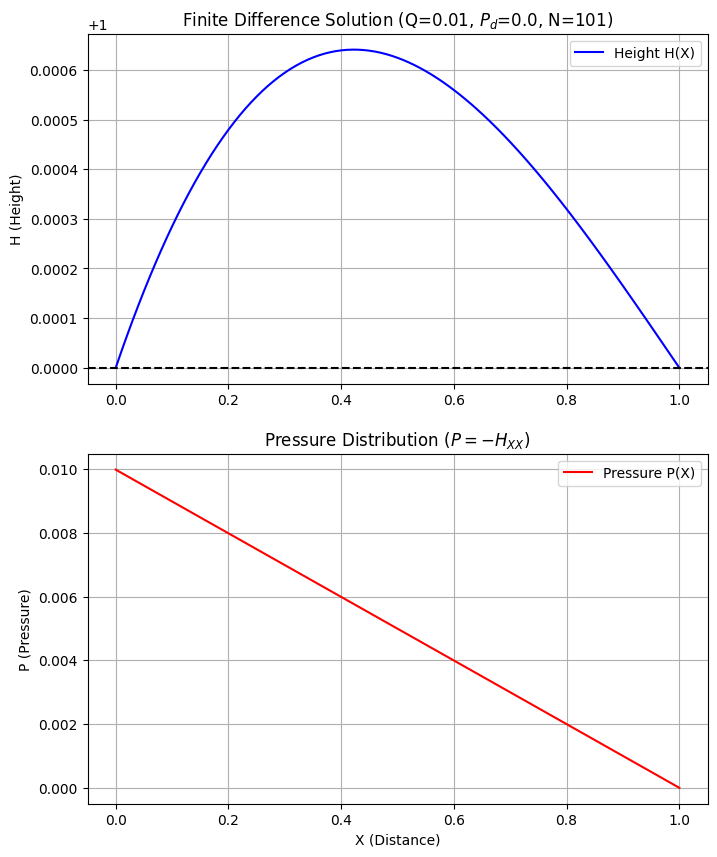

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

def solve_finite_difference_tube(N=101, Q=0.01, Pd=0.0, max_iter=1001, tol=1e-6):
    # Grid Setup, domain X in [0, 1], N nodes with indices 0 to N-1
    dx = 1.0 / (N - 1)
    x_grid = np.linspace(0, 1, N)

    # Initial guess of a tube of height 1 everywhere
    H = np.ones(N)

    # Newton-Raphson loop
    for iteration in range(max_iter):

        # Initialise Residual Vector F and Jacobian Matrix J
        # We use sparse matrices
        J = lil_matrix((N, N))
        F = np.zeros(N)

        # Row 0: Upstream boundary condition: H(0) = 1
        F[0] = H[0] - 1.0
        J[0, 0] = 1.0

        # Rows 2 to N-2: The ODE equations discretised ODE at interior points

        # Central difference ODE
        coeff_central = np.array([-1, 2, 0, -2, 1]) / (2 * dx**3)
        # Stencil offsets relative to i: [-2, -1, 0, 1, 2]

        for i in range(2, N - 2):
            # Extract local H values
            # Indices for the stencil
            idxs = [i-2, i-1, i, i+1, i+2]
            H_local = H[idxs]

            # Calculate H''' (H_xxx)
            H_xxx = np.dot(coeff_central, H_local)

            # Residual: H''' * H^3 - Q = 0
            F[i] = H_xxx * (H[i]**3) - Q

            # Jacobian Entries: dF/dH_k
            # dF/dH_k = (dH'''/dH_k) * H^3 + H''' * (3*H^2 * dH/dH_k)
            for k_idx, node_idx in enumerate(idxs):
                c = coeff_central[k_idx] # Contribution to H'''

                term1 = c * (H[i]**3)
                term2 = 0
                if node_idx == i:
                    term2 = H_xxx * 3 * (H[i]**2)

                J[i, node_idx] = term1 + term2

        # Near-boundary ODE
        i = N - 2
        coeff_back_ode = np.array([1, -6, 12, -10, 3]) / (2 * dx**3)
        idxs = [i-3, i-2, i-1, i, i+1]

        H_local = H[idxs]
        H_xxx = np.dot(coeff_back_ode, H_local)

        F[i] = H_xxx * (H[i]**3) - Q

        for k_idx, node_idx in enumerate(idxs):
            c = coeff_back_ode[k_idx]
            term1 = c * (H[i]**3)
            term2 = 0
            if node_idx == i:
                term2 = H_xxx * 3 * (H[i]**2)
            J[i, node_idx] = term1 + term2

        # Row N-1: Downstream boundary condition: H(L) = 1
        F[N-1] = H[N-1] - 1.0
        J[N-1, N-1] = 1.0

        # Row 1: Downstream pressure boundary condition: H''(1) = -Pd
        coeff_pres = np.array([-1, 4, -5, 2]) / (dx**2)
        idxs = [N-4, N-3, N-2, N-1]

        H_local = H[idxs]
        H_xx = np.dot(coeff_pres, H_local)

        # Residual: H'' + Pd = 0
        F[1] = H_xx + Pd

        # Jacobian for this row
        for k_idx, node_idx in enumerate(idxs):
            J[1, node_idx] = coeff_pres[k_idx]

        # Solve linear system
        J_csr = J.tocsr()

        # Check convergence
        resid_norm = np.linalg.norm(F, np.inf)
        if resid_norm < tol:
            print(f"Converged in {iteration} iterations. Residual: {resid_norm:.2e}")
            break

        # Newton Update: J * delta_H = -F
        try:
            delta_H = spsolve(J_csr, -F)
        except RuntimeError:
            print("Singular Matrix encountered. Adjusting guess.")
            delta_H = -0.1 * F # Fallback gradient descent step

        # Apply update
        H = H + delta_H

        # Height cannot be negative
        H[H < 1e-4] = 1e-4

    else:
        print("Did not converge within max_iter.")

    # Calculate pressure distribution P(x) = -H''(x)
    P = np.zeros(N)

    # Interior central difference for H''
    for i in range(1, N-1):
        P[i] = -(H[i-1] - 2*H[i] + H[i+1]) / (dx**2)

    # Boundaries linear extrapolation
    P[0] = 2*P[1] - P[2]
    P[N-1] = Pd

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(x_grid, H, 'b-', linewidth=1.5, label='Height H(X)')
    plt.axhline(1.0, color='k', linestyle='--')
    plt.title(f'Finite Difference Solution (Q={Q}, $P_d$={Pd}, N={N})')
    plt.ylabel('H (Height)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x_grid, P, 'r-', label='Pressure P(X)')
    plt.title('Pressure Distribution ($P = -H_{XX}$)')
    plt.xlabel('X (Distance)')
    plt.ylabel('P (Pressure)')
    plt.grid(True)
    plt.legend()

    plt.show()

solve_finite_difference_tube()